In [2]:
import os
import numpy as np
import scipy.io
import pywt

from scipy.signal import hilbert, freqz
from matplotlib import pyplot as plt

from typing import List, Tuple

# Functions

In [3]:
def Load(file: str) -> Tuple[List]:

    DATA = scipy.io.loadmat(os.path.join('Data', file))
    x = DATA['bearing']['gs'][0][0]
    fs = DATA['bearing']['sr'][0][0][0]
    time = np.transpose(np.arange(0, len(x)) / fs)

    return x, fs, time, DATA


def PSD(f: List, time: List, num: int) -> Tuple[List]:

    dt = abs(time[2] - time[1])
    n = len(time[:num])
    fhat = np.fft.fft(f[:num], n)
    freq = (1/(dt*n))*np.arange(n)
    psd = fhat*np.conj(fhat) / n
    L = np.arange(1, np.floor(n/2), dtype='int')

    return freq, psd, L

def plot_psd(freq, psd, L, title=''):

    plt.figure()
    plt.plot(freq[L], psd[L])
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel('Freq [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.title(f'PSD: {title}')




def Spec(f: List, fs: int, title: str=""):

    plt.figure()
    plt.title(title)
    plt.specgram(f, NFFT=1024, Fs=fs, noverlap=120,cmap='jet')
    plt.colorbar()


def wavelet_filter(coefficients, wavelet) -> List:
    
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coefficients)

    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

    keep = 0.05

    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec')

    # Plot reconstruction
    Arecon = pywt.waverec(coeffs_filt,wavelet=wavelet)

    return Arecon


def env_spectrum(x, fs):

    analytic_signal = hilbert(x)
    envelope = np.abs(analytic_signal)
    
    
    f_env = np.fft.fftfreq(len(envelope), d=1/fs)
    p_env = np.abs(np.fft.rfft(envelope) / len(x))
    
    
    x_env = envelope
    
    return p_env, f_env, x_env, 


def plot_env_spectrum(x_env, x_raw, time):

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.xlim(0.04, 0.06)
    plt.plot(time, x_raw)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(x_env)], x_env)
    plt.xlim(0.04, 0.06)
    # plt.ylim(0, 1)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')

def plot_env_spectrum_analysis(f_env, p_env, BP, BPFI=False, BPFO=False, ALL=False):
    
    k = 0
    ncomb = 0
    if ALL: BPFI = BPFO = True

    plt.figure()
    a = next((index for index, value in enumerate(f_env) if value > 1000), -1)
    plt.plot(f_env[3:a], p_env[3:a], label='Envelope Spectrum')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel('Peak Amplitude')
    plt.xlim(0, 1000)
    plt.ylim( 0, 0.5)

    if BPFI:
        values = []
        while k * BP["BPFI"] < 1000: 
            values.append(k * BP["BPFI"])
            k +=1
        harmonics = dict(values=values, name="BPFI")
        plt.vlines(harmonics['values'], 0, 0.5, colors='r', linestyles='--', label=harmonics['name'])
    if BPFO:
        values = []
        while ncomb * BP["BPFO"] < 1000: 
            values.append(ncomb * BP["BPFO"])
            ncomb +=1
        harmonics = dict(values=values, name="BPFO")
        plt.vlines(harmonics['values'], 0, 0.5, colors='#f87915', linestyles='--', label=harmonics['name'])

    plt.legend(framealpha=1)




# Analysis

## Inner Fault 1

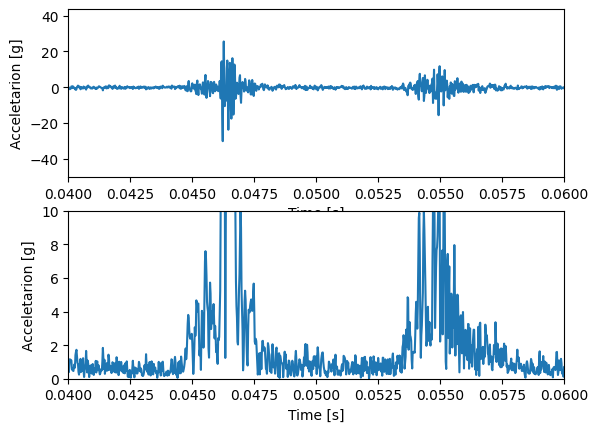

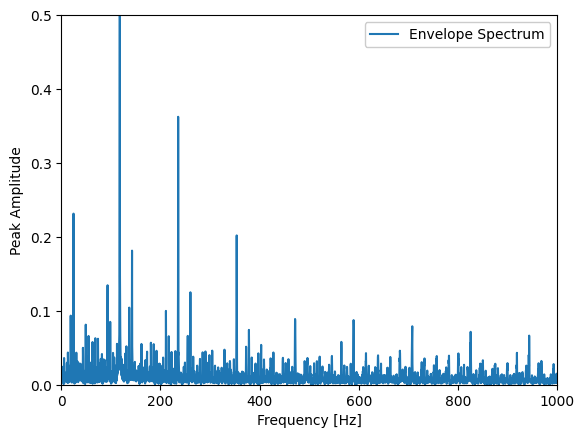

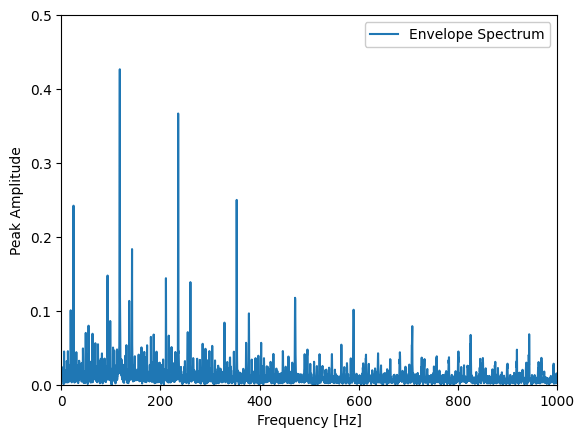

In [4]:
file_to_load = 'InnerRaceFault_vload_1.mat'
title = file_to_load.split('.')[0]


x_IRF_1, f_IRF_1, t_IRF_1, IRFDATA = Load(file_to_load)



num = int(len(t_IRF_1)*0.001)

freq, psd, L = PSD(x_IRF_1, t_IRF_1, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(x_IRF_1[:num])[0], f_IRF_1[0], title)

p_env, f_env, x_env = env_spectrum(np.transpose(x_IRF_1[:])[0],  f_IRF_1[0])



plot_env_spectrum(x_env, x_IRF_1, t_IRF_1)
plt.ylim(0, 10)

plot_env_spectrum_analysis(f_env, p_env, IRFDATA)

# Wavelet

wavelet='db1'
scales = (1, len(x_IRF_1))
coeffs = pywt.wavedec(x_IRF_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon Inner Fault 1"

p_env, f_env, x_env = env_spectrum(np.transpose(recon)[0],  f_IRF_1[0])


plot_env_spectrum_analysis(f_env, p_env, IRFDATA)





## Baseline 1

c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Usuario\Documents\Python\Rolling-Fault-FFT-Wavelet-Analysis\env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


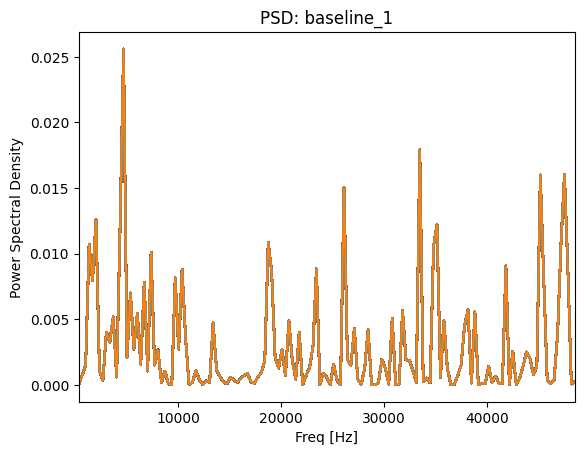

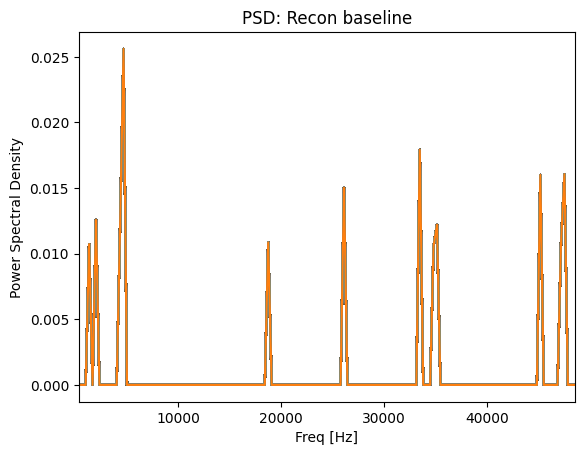

In [5]:
file_to_load = 'baseline_1.mat'
title = file_to_load.split('.')[0]

x_bsln_1, f_bsln_1, t_bsln_1, BSLN_DATA = Load(file_to_load)
num = int(len(t_bsln_1)*0.0005)

freq, psd, L = PSD(x_bsln_1, t_bsln_1, num)

plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_bsln_1[:num])[0], f_bsln_1[0], title)


#Wavelet test

wavelet='db1'
scales = (1, len(x_bsln_1))
coeffs = pywt.wavedec(x_bsln_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon baseline"

freq, psd, L = PSD(recon, t_bsln_1, num)

plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')


## Envelope Spectrum: Normal

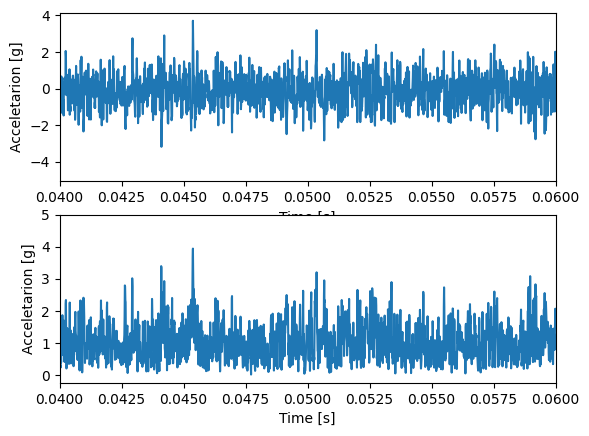

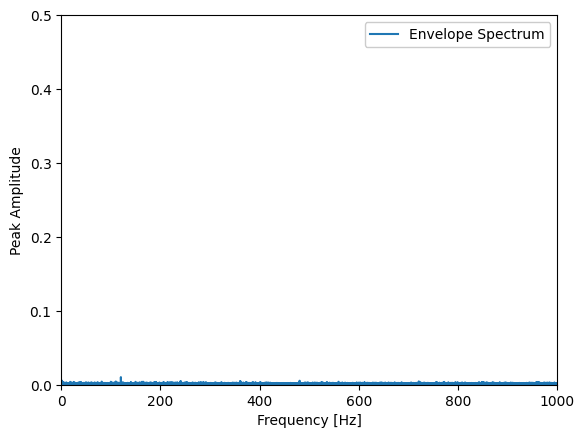

In [6]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_bsln_1)[0],  f_bsln_1[0])

plot_env_spectrum(x_env, x_bsln_1, t_bsln_1)

plot_env_spectrum_analysis(f_env, p_env, BSLN_DATA)


# Outer Fault Analysis


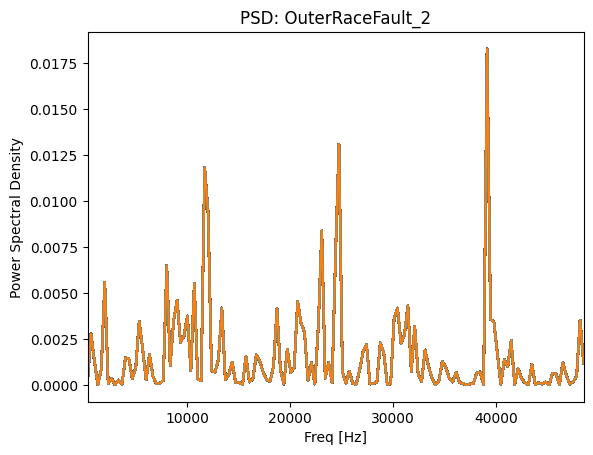

In [7]:
file_to_load = 'OuterRaceFault_2.mat'
title = file_to_load.split('.')[0]

x_ORF_2, f_ORF_2, t_ORF_2, ORF_DATA = Load(file_to_load)
num = int(len(t_ORF_2)*0.0005)

freq, psd, L = PSD(x_ORF_2, t_ORF_2, num)

plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_ORF_2[:num])[0], f_ORF_2[0], title)


#Wavelet test

# wavelet='db1'
# scales = (1, len(x_ORF_2))
# coeffs = pywt.wavedec(x_ORF_2, wavelet)

# recon = wavelet_filter(coeffs, wavelet)
# title = "Recon baseline"

# freq, psd, L = PSD(recon, t_ORF_2, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')

## Envelope Spectrum: Outer Fault

(0.0, 0.1)

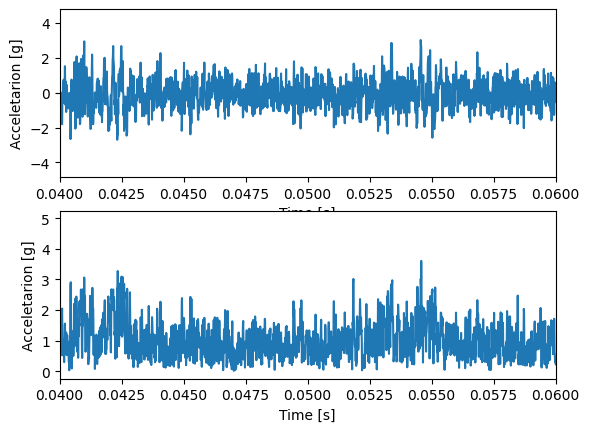

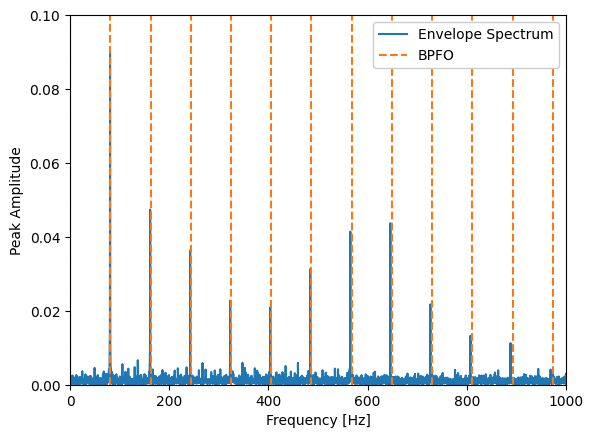

In [8]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_ORF_2)[0],  f_ORF_2[0])

plot_env_spectrum(x_env, x_ORF_2, t_ORF_2)

plot_env_spectrum_analysis(f_env, p_env, ORF_DATA, BPFO=True)
plt.ylim(0, 0.1)

In [9]:
pywt.cwt(np.transpose(x_ORF_2)[0][:5], 2, 'gaus1')

(array([[-0.3646155 , -0.53587924, -0.45282098,  0.10009352,  0.61933131]]),
 array([0.1]))

In [14]:
k = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 786, 1024]
a = []

for v in k:
    a.append(pywt.cwt(np.transpose(x_ORF_2)[0], v, 'gaus1', method='fft'))

a

[(array([[-0.36329049, -0.52273363, -0.37012807, ..., -0.59679498,
          -0.24751756, -0.37503744]]),
  array([0.1])),
 (array([[-0.31246448, -0.05481792,  0.32779422, ..., -1.36824051,
          -1.43379335, -1.44595949]]),
  array([0.05])),
 (array([[ 0.01283707,  0.17138621,  0.32309416, ..., -1.56690338,
          -1.83518549, -1.96014848]]),
  array([0.03333333])),
 (array([[ 0.08316355,  0.17342417,  0.2306941 , ..., -1.37930287,
          -1.68191758, -1.90275471]]),
  array([0.025])),
 (array([[ 0.11353152,  0.1550217 ,  0.19988748, ..., -0.96036896,
          -1.22372834, -1.48722314]]),
  array([0.01666667])),
 (array([[ 0.12210481,  0.16611661,  0.15914942, ..., -0.66431572,
          -0.93693802, -1.11029074]]),
  array([0.0125])),
 (array([[ 0.39478887,  0.4567618 ,  0.3758507 , ..., -0.67899143,
          -0.65593011, -0.88799689]]),
  array([0.00833333])),
 (array([[ 0.58581416,  0.60584784,  0.68699973, ..., -0.91547003,
          -0.88845563, -1.00747431]]),
  arra

In [15]:
p = [j[0][0] for j in a]
p=np.stack(p)
p


array([[-0.36329049, -0.52273363, -0.37012807, ..., -0.59679498,
        -0.24751756, -0.37503744],
       [-0.31246448, -0.05481792,  0.32779422, ..., -1.36824051,
        -1.43379335, -1.44595949],
       [ 0.01283707,  0.17138621,  0.32309416, ..., -1.56690338,
        -1.83518549, -1.96014848],
       ...,
       [ 3.90728652,  2.42031188,  1.79059105, ..., -1.70210406,
        -1.99121374, -3.85887075],
       [ 3.39710935,  2.36679813,  3.98602553, ..., -2.11433834,
        -3.78069207, -3.87908113],
       [ 1.58162496,  3.91940452,  6.51562345, ..., -5.40051585,
        -4.39740904, -2.36130645]])

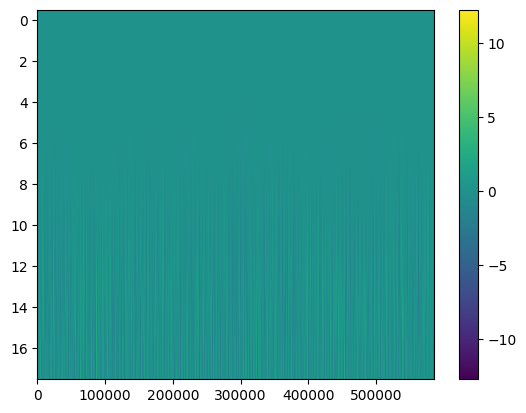

In [16]:
plt.figure()
plt.imshow(np.stack(p), aspect='auto')
plt.colorbar()